In [254]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats
import copy
import YahooStocks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Yahoo Data (5 minute interval)

In [255]:
tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
stocks.get_PSQL('stocks', 'postgres', '10.0.0.26')

In [256]:
create_table_sql = """CREATE TABLE StockPrice (
id serial PRIMARY KEY,
datetime TIMESTAMP,
symbol VARCHAR ( 10 ),
price FLOAT
);"""

In [257]:
#stocks.PSQL.execute(create_table_sql)

In [258]:
stocks.PSQL.execute('COMMIT;')

In [259]:
# Download Yahoo and transform
stocks.get_data(interval = '15m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [260]:
stocks.raw_data.shape

(130, 126)

In [261]:
tmp = copy.copy(stocks.transformed_data)
stocks.transformed_data = tmp

In [262]:
stocks.transformed_data.iloc[0] = ['AAPL', 120]

In [263]:
stocks.transformed_data.to_csv('data/mydata.csv')

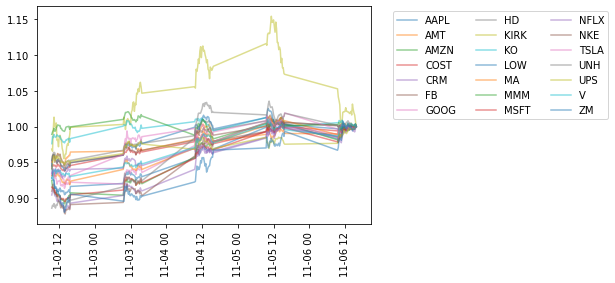

In [264]:
stocks.plot_raw(scale = -1)

# Model

In [265]:
stocks.transformed_data

,symbol,price
DateTime,,
2020-11-06 15:45:00,AAPL,120.000000
2020-11-03 11:45:00,AAPL,110.904999
2020-11-03 12:00:00,AAPL,110.655800
2020-11-03 12:15:00,AAPL,111.035004
2020-11-03 12:30:00,AAPL,110.732399
...,...,...
2020-11-05 13:30:00,ZM,487.747498
2020-11-05 13:45:00,ZM,488.529999
2020-11-05 14:00:00,ZM,486.570007


In [266]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Note if pulling from SQL index = 'DateTime'
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [267]:
from statsmodels.tsa.stattools import adfuller

https://otexts.com/fpp2/VAR.html  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [268]:
stationarity = []
lags = []
for s in data.columns:
    xdiff = data[s].diff().dropna().values
    x = data[s].values
    no_lag, one_lag = adfuller(x), adfuller(xdiff)
    stationarity.append([no_lag[1], one_lag[1]])
    lags.append([no_lag[2], one_lag[2]])
stationarity = pd.DataFrame(stationarity)
lags = pd.DataFrame(lags)

In [269]:
stationarity

,0,1
0,0.902000,4.868207e-21
1,0.430757,1.047290e-19
2,0.844840,1.443795e-21
3,0.620624,2.778660e-20
4,0.854025,9.438120e-18
5,0.813708,2.202570e-20
6,0.713663,8.374737e-19
7,0.381617,4.872911e-20
8,0.749932,7.983543e-07
9,0.053254,8.870459e-23


In [270]:
data = data.diff().dropna()

In [271]:
# Mean absolute scaled error
def get_MASE(data,lags):
    # Calculate Q for each series. MAE of naive forecast for each series
    Q = np.abs(data.diff().dropna()).mean()
    #print(Q)
    # Calculate MASE for each series as 
    MASE = []
    MASEN = []
    n_ahead = 1
    # rolling origin point forecasts.
    # has to train on at least n = lags samples
    for n in range(lags,(data.shape[0] - 1)):
        try:
            M = YahooStocks.Model(data=data.iloc[0:n])
            M.fitVAR(lags)
            #print(M.results.aic)
            M.forecast(n_ahead)
            MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
            MAE = np.abs((data.iloc[n].values - M.fcast.values))[0]
            MASE.append(MAE/Q)
            MASEN.append(MAEnaive/Q)
        except:
            continue
    return MASE, MASEN

In [272]:
# 75 lags corresponds to a full day
lags = 60
MASE, MASEN = get_MASE(data, lags)

# Significance Testing

In [274]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

0.75055110753129
0.8757949223273072


Ttest_relResult(statistic=-3.8334978965368705, pvalue=0.00013199967130385592)

In [223]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
print(stats.ttest_ind(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL']))

# pairwise ttest between naive and var. Nobody looks significant, if so its green jelly beans
# e.g. aapl naive to aapl var for all stocks
# Just a reminder, anova would allow for comparison between mase, masen, and others. just two here so ttest suffices.
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

Ttest_indResult(statistic=-0.2723073723413668, pvalue=0.7859255858080578)


array([0.78592559, 0.77581457, 0.4931518 , 0.66106155, 0.60968222,
       0.61054695, 0.35706239, 0.99720314, 0.14624051, 0.47067163,
       0.35676355, 0.60743066, 0.4210947 , 0.48761286, 0.88453948,
       0.50309127, 0.8913747 , 0.85082211, 0.38809858, 0.54645895,
       0.17357072])

In [212]:
# Are there any stocks that are more predictable than others? Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.18270865337096798, pvalue=0.9999771178638632)

-0.15402072685357307


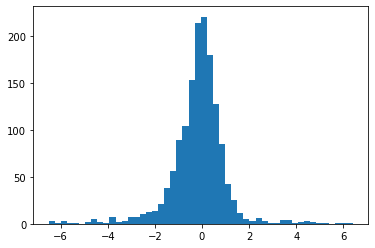

In [213]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

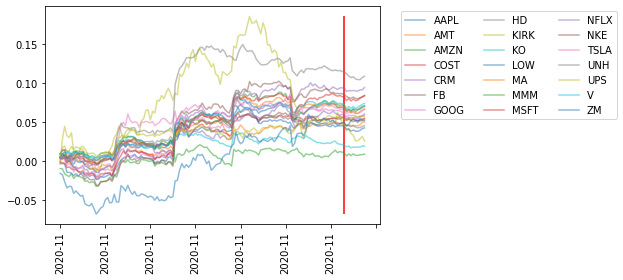

In [214]:
M = YahooStocks.Model(data=data.iloc[0:-3])
M.fitVAR(lags)
M.forecast(10)
integration = pd.concat((M.data, M.fcast)).cumsum()
M.data = integration.head(M.data.shape[0])
M.fcast = integration.tail(10)
M.plot_fcast()

In [215]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
UNH     0.114535
CRM     0.093841
FB      0.085380
MSFT    0.081872
V       0.072612
AMZN    0.070415
MA      0.068253
AAPL    0.067981
GOOG    0.063868
TSLA    0.061080
NFLX    0.058580
COST    0.055319
NKE     0.054173
UPS     0.054119
ZM      0.048868
HD      0.048049
AMT     0.047352
KIRK    0.046193
LOW     0.044640
KO      0.020446
MMM     0.010520
Name: 126, dtype: float64